<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%207%20/%20Tugas%20/%20TensorFlow_DeepRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Functions

In [1]:
!pip install tensorflow keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, MaxPooling1D, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import os
import json
import re

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Device
tf.keras.mixed_precision.set_global_policy('mixed_float16')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

print("GPU Available:", tf.config.list_physical_devices('GPU'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Parameters
BATCH_SIZE = 64
EPOCHS = 10
EPOCHS_TUNER = 4
validation_split = 0.2

# Preprocessing
def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    x = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return x, y, tokenizer

In [4]:
# Build model
def build_model(hp, max_features, max_length):

    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', 8, 256, step=64)
    ))

    BiRNN_units = hp.Int('BiRNN_units', 64, 256, step=64)
    dropout_rate = hp.Float('BiRNN_dropout', 0.3, 0.5, step=0.1)
    num_layers = hp.Int('num_layers', 2, 3, step=1)

    for i in range(num_layers):
        model.add(Bidirectional(LSTM(
            units=BiRNN_units,
            activation='tanh',
            recurrent_activation='sigmoid',
            use_bias=True,
            kernel_initializer='glorot_uniform',
            recurrent_initializer='orthogonal',
            bias_initializer='zeros',
            unit_forget_bias=True,
            kernel_regularizer=regularizers.l2(0.001),
            dropout=dropout_rate,
            return_sequences=True if i < num_layers - 1 else False
        )))
        model.add(tf.keras.layers.LayerNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(BiRNN_units * 2, activation="relu",
                    kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [5]:
# Evaluation and visualization
def evaluate_and_visualize(model, x_train, y_train, x_test, y_test, dataset_name):
    history = model.fit(
        x_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test)
    )

    y_prob = model.predict(x_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_sq = f1_score(y_test, y_pred)**2
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"F1 Squared: {f1_sq:.4f}")
    print(f"AUC      : {auc:.4f}")

    # ROC Curve
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Accuracy graph
    plt.figure()
    plt.plot(history.history['accuracy'], label="Train Accuracy", color='blue', marker='.')
    plt.plot(history.history['val_accuracy'], label="Val Accuracy", color='red', marker='.')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Loss graph
    plt.figure()
    plt.plot(history.history['loss'], label="Train Loss", color='blue', marker='.')
    plt.plot(history.history['val_loss'], label="Val Loss", color='red', marker='.')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_sq': f1_sq,
        'auc': auc,
        'history': history.history
    }

    # Save to global results
    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "F1 Squared": f1_sq,
        "AUC": auc
    }

#IMDB

In [6]:
MAX_FEATURES = 30000
MAX_LENGTH = 300

# Dataset
def IMDB_dataset():
    from tensorflow.keras.datasets import imdb

    # Load the IMDb dataset
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

    # Pad the sequences to the same length
    x_train = pad_sequences(x_train, maxlen=MAX_LENGTH)
    x_test = pad_sequences(x_test, maxlen=MAX_LENGTH)

    return x_train, y_train, x_test, y_test

Trial 10 Complete [00h 03m 33s]
val_accuracy: 0.7757999897003174

Best val_accuracy So Far: 0.8727999925613403
Total elapsed time: 00h 19m 31s

Best Hyperparameters:
embedding_dim: 72
BiRNN_units: 64
BiRNN_dropout: 0.5
num_layers: 2
learning_rate: 0.0003680880592024201
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0001
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.5207 - loss: 1.3747 - val_accuracy: 0.7406 - val_loss: 0.9749
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.7985 - loss: 0.8765 - val_accuracy: 0.8286 - val_loss: 0.7548
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.8879 - loss: 0.6061 - val_accuracy: 0.8604 - val_loss: 0.6442
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.9195 - loss: 0.4697 - val_accuracy: 0.8592 - val_loss: 0.6087
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - accuracy: 0.9408 - loss: 0.3676 - val_accuracy: 0.8262 - val_l

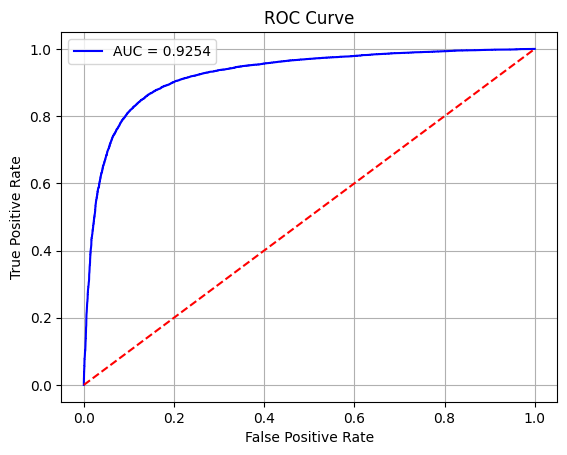

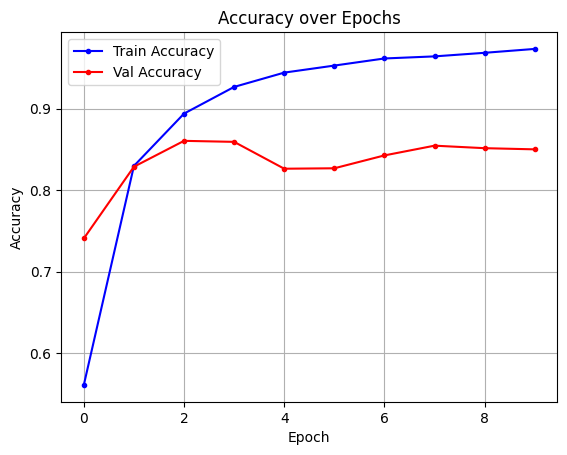

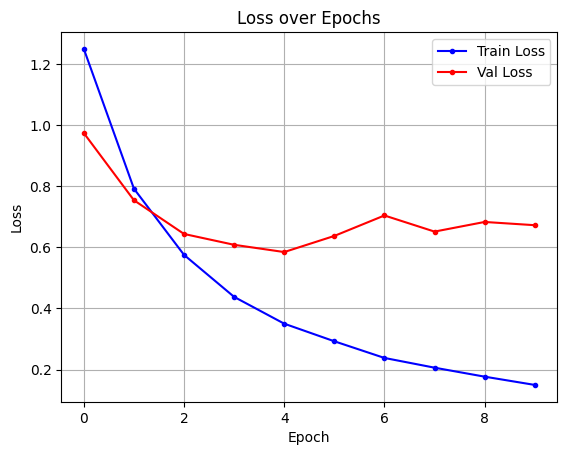

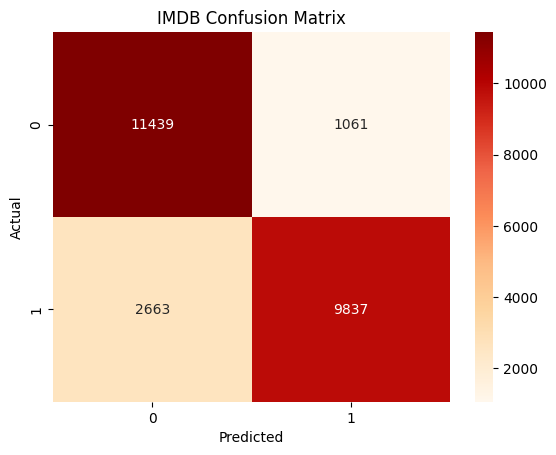

In [7]:
# Execution
def run(dataset_name, prepare_data_fn, max_features, max_length):
    x_train, y_train, x_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=None,
        project_name=dataset_name
    )

    tuner.search(x_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    results = evaluate_and_visualize(model, x_train, y_train, x_test, y_test, dataset_name)

    return model, results

# Running
model, results = run("IMDB", IMDB_dataset, MAX_FEATURES, MAX_LENGTH)

#Review Toko Baju

In [8]:
MAX_FEATURES = 10000
MAX_LENGTH = 100

# Dataset
def ReviewTokoBaju_dataset():
    file_path = "ReviewTokoBaju.csv"
    df = pd.read_csv(file_path)

    df = df.drop_duplicates()
    df = df[['Review Text', 'Recommended IND']].dropna()
    df['label'] = df['Recommended IND'].astype(int)

    texts = df['Review Text'].astype(str).tolist()
    labels = df['label'].tolist()

    x, y, tokenizer = preprocess_text_data(texts, labels, MAX_FEATURES, MAX_LENGTH)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

    return x_train, y_train, x_test, y_test

Trial 10 Complete [00h 02m 16s]
val_accuracy: 0.807341992855072

Best val_accuracy So Far: 0.8760695457458496
Total elapsed time: 00h 08m 55s

Best Hyperparameters:
embedding_dim: 72
BiRNN_units: 192
BiRNN_dropout: 0.4
num_layers: 2
learning_rate: 0.0004789261577663581
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8032 - loss: 1.8222 - val_accuracy: 0.8529 - val_loss: 1.0182
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8826 - loss: 0.8880 - val_accuracy: 0.8291 - val_loss: 0.7545
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8998 - loss: 0.6129 - val_accuracy: 0.8161 - val_loss: 0.6453
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9133 - loss: 0.4571 - val_accuracy: 0.8792 - val_loss: 0.4853
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9264 - loss: 0.3508 - val_accuracy: 0.8717 - val_loss: 0.4425
Epoch 6/1

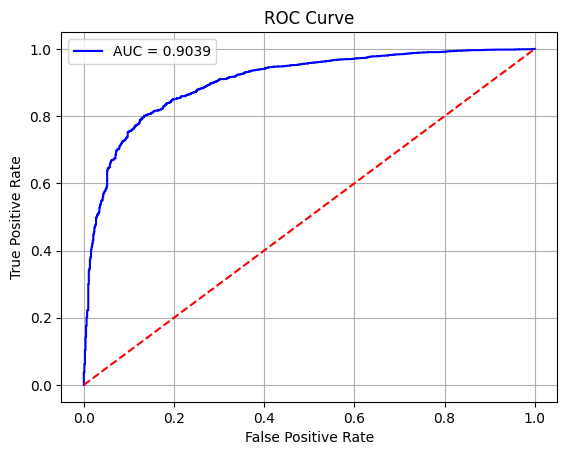

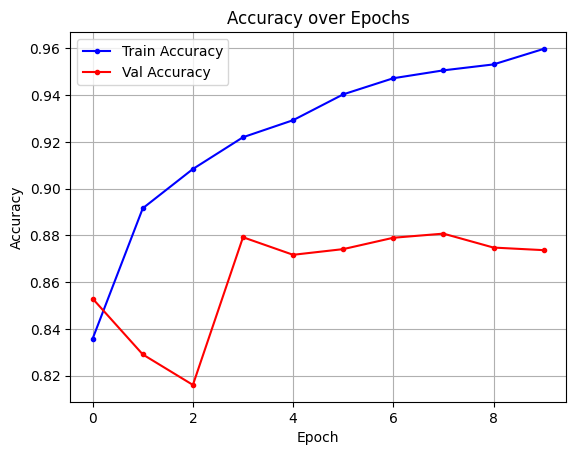

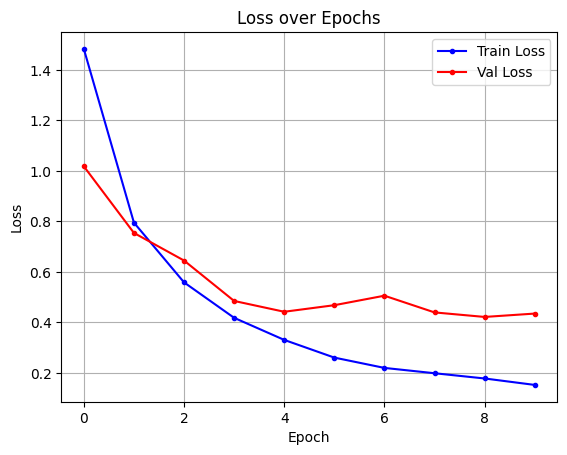

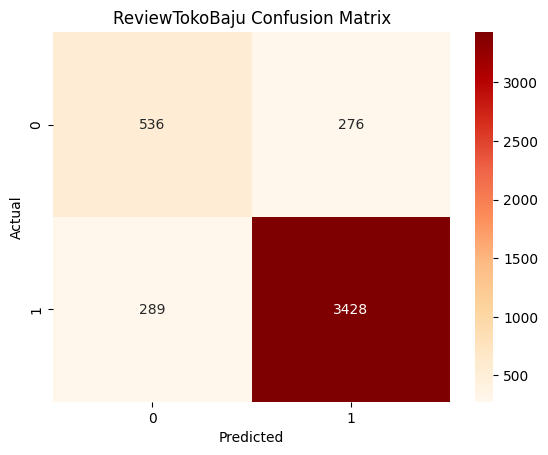

In [9]:
# Execution
def run(dataset_name, prepare_data_fn, max_features, max_length):
    x_train, y_train, x_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=f'tuner_{dataset_name}',
        project_name=dataset_name
    )

    tuner.search(x_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    results = evaluate_and_visualize(model, x_train, y_train, x_test, y_test, dataset_name)

    return model, results

# Running
model, results = run("ReviewTokoBaju", ReviewTokoBaju_dataset, MAX_FEATURES, MAX_LENGTH)

#Deteksi Sarkasme

In [10]:
MAX_FEATURES = 10000
MAX_LENGTH = 50

# Dataset
MAX_FEATURES = 10000
MAX_LENGTH = 35

def DeteksiSarkasme_dataset():
    file_path = "DeteksiSarkasme.json"

    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    df = df.drop_duplicates()

    # Preprocessing
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['processed_headline'] = df['headline'].apply(preprocess_text)

    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='')
    tokenizer.fit_on_texts(df['processed_headline'])
    sequences = tokenizer.texts_to_sequences(df['processed_headline'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

    vocab_size = min(MAX_FEATURES, len(tokenizer.word_index) + 1)

    x = padded_sequences
    y = np.array(df['is_sarcastic'])

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=seed, stratify=y
    )

    return x_train, y_train, x_test, y_test

Trial 10 Complete [00h 00m 40s]
val_accuracy: 0.8476836681365967

Best val_accuracy So Far: 0.8476836681365967
Total elapsed time: 00h 06m 02s

Best Hyperparameters:
embedding_dim: 200
BiRNN_units: 128
BiRNN_dropout: 0.3
num_layers: 2
learning_rate: 0.0004498392741418699
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6834 - loss: 1.7847 - val_accuracy: 0.8461 - val_loss: 1.0185
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8814 - loss: 0.8754 - val_accuracy: 0.8484 - val_loss: 0.8101
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9272 - loss: 0.5773 - val_accuracy: 0.8396 - val_loss: 0.7346
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9452 - loss: 0.4178 - val_accuracy: 0.8343 - val_loss: 0.6813
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9613 - loss: 0.3048 - val_accuracy: 0.8458 - val_loss: 0.6713
Epoch 6/1

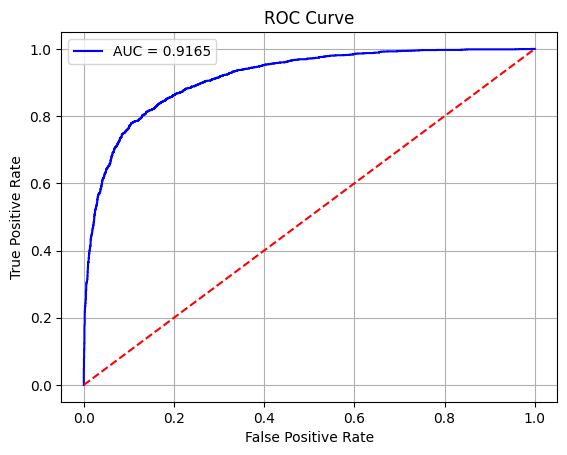

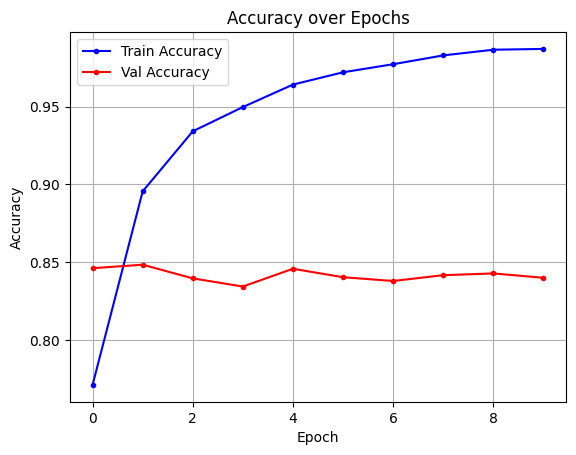

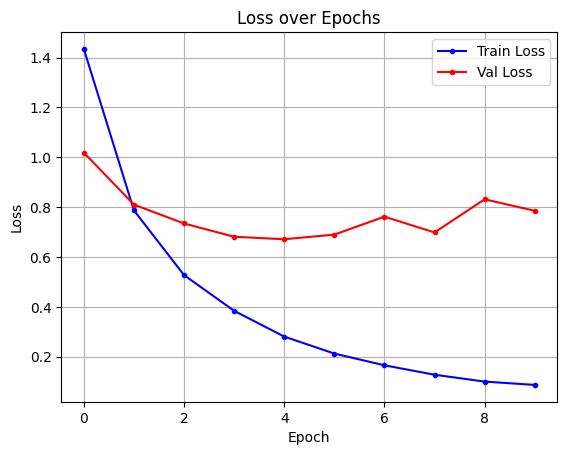

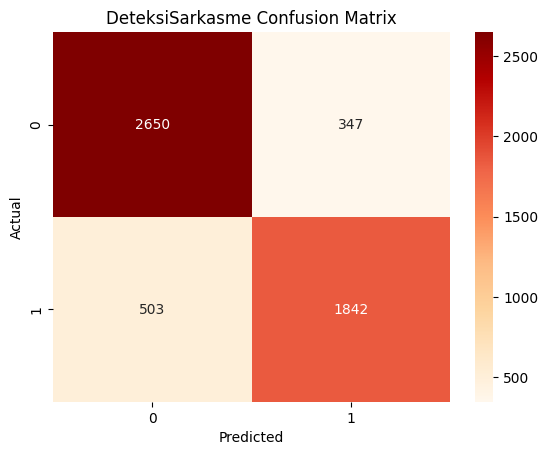

In [11]:
# Execution
def run(dataset_name, prepare_data_fn, max_features, max_length):

    x_train, y_train, x_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        overwrite=True
    )

    print(f"\nTuning model for {dataset_name}...")
    tuner.search(
        x_train, y_train,
        epochs=EPOCHS_TUNER,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    best_model = tuner.hypermodel.build(best_hps)

    results = evaluate_and_visualize(
        best_model, x_train, y_train, x_test, y_test,
        dataset_name
    )

    return best_model, results

#Running
results = {}
model, res = run("DeteksiSarkasme", DeteksiSarkasme_dataset, MAX_FEATURES, MAX_LENGTH)
results["DeteksiSarkasme"] = res